# Ablation Study 1: Model variation in hyperparameters

In [12]:
"""
Hyperparameter Ablation Study
Tests various hyperparameters for LSTM, TFT, and XGBoost models
"""

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
from typing import Dict, List, Tuple
from itertools import product

# Import custom modules
from xgb import flatten_sequences, train_xgb_classifier, XGBTrainConfig
from lstm import train_dual_head_classifier, TrainConfig as LSTMTrainConfig
from tft import train_tft_classifier, TrainConfig as TFTTrainConfig
from data_prep import add_over_under_label, prepare_receiving_sequences
from metrics import compute_ece, compute_pace
from sklearn.metrics import roc_auc_score

%matplotlib inline

# CONFIGURATION
YARD_TYPE = "receiving"
STAT_COL = "YDS"
LINE_VALUE = 80
N_PAST_GAMES = 5
HIDDEN_SIZE = 128
D_MODEL = 128


##  Hyperparameter ranges to test  ##
EPOCHS_RANGE = [10, 20, 30]
BATCH_SIZE_RANGE = [32, 64, 128]
LEARNING_RATE_RANGE = [1e-4, 5e-4, 1e-3]
XGB_ESTIMATORS_RANGE = [200, 300, 400, 500]
XGB_MAX_DEPTH_RANGE = [3, 4, 5, 6]



def train_and_evaluate_lstm(
    X_train: np.ndarray,
    y_train: np.ndarray,
    lengths_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    lengths_test: np.ndarray,
    hidden_size: int,
    n_epochs: int,
    batch_size: int,
    lr: float,
    param_name: str,
    param_value: any
) -> Dict[str, float]:
    """Train LSTM model and return metrics"""
    
    cfg = LSTMTrainConfig(
        n_epochs=n_epochs,
        batch_size=batch_size,
        lr=lr,
        device="auto",
        verbose=False,
    )
    
    print(f"  Training LSTM ({param_name}={param_value})...", end=" ")
    train_result = train_dual_head_classifier(
        X=X_train,
        y=y_train,
        lengths=lengths_train,
        hidden_size=hidden_size,
        cfg=cfg,
    )
    
    model = train_result["model"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Test metrics
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    len_test_t = torch.tensor(lengths_test, dtype=torch.long).to(device)
    
    with torch.no_grad():
        _, logits_test = model(X_test_t, len_test_t)
        probs_test = torch.sigmoid(logits_test).cpu().numpy()
    
    y_true_test = np.asarray(y_test)
    auc_test = roc_auc_score(y_true_test, probs_test)
    ece_test = compute_ece(y_true_test, probs_test)
    pace2_test = compute_pace(y_true_test, probs_test, L=2)
    
    print("Done")
    
    return {
        "test_auc": auc_test,
        "test_ece": ece_test,
        "test_pace2": pace2_test,
    }


def train_and_evaluate_tft(
    X_train: np.ndarray,
    y_train: np.ndarray,
    lengths_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    lengths_test: np.ndarray,
    d_model: int,
    n_epochs: int,
    batch_size: int,
    lr: float,
    param_name: str,
    param_value: any
) -> Dict[str, float]:
    """Train TFT model and return metrics"""
    
    cfg = TFTTrainConfig(
        n_epochs=n_epochs,
        batch_size=batch_size,
        lr=lr,
        device="auto",
        verbose=False,
    )
    
    print(f"  Training TFT ({param_name}={param_value})...", end=" ")
    train_result = train_tft_classifier(
        X=X_train,
        y=y_train,
        lengths=lengths_train,
        d_model=d_model,
        n_heads=4,
        num_layers=2,
        dropout=0.1,
        cfg=cfg,
    )
    
    model = train_result["model"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Test metrics
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    len_test_t = torch.tensor(lengths_test, dtype=torch.long).to(device)
    
    with torch.no_grad():
        _, logits_test = model(X_test_t, len_test_t)
        probs_test = torch.sigmoid(logits_test).cpu().numpy()
    
    y_true_test = np.asarray(y_test)
    auc_test = roc_auc_score(y_true_test, probs_test)
    ece_test = compute_ece(y_true_test, probs_test)
    pace2_test = compute_pace(y_true_test, probs_test, L=2)
    
    print("Done")
    
    return {
        "test_auc": auc_test,
        "test_ece": ece_test,
        "test_pace2": pace2_test,
    }


def train_and_evaluate_xgb(
    X_train: np.ndarray,
    y_train: np.ndarray,
    lengths_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    lengths_test: np.ndarray,
    n_estimators: int,
    max_depth: int,
    param_name: str,
    param_value: any
) -> Dict[str, float]:
    """Train XGBoost model and return metrics"""
    
    cfg = XGBTrainConfig(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        verbose=False,
    )
    
    print(f"  Training XGBoost ({param_name}={param_value})...", end=" ")
    train_result = train_xgb_classifier(
        X=X_train,
        y=y_train,
        lengths=lengths_train,
        cfg=cfg,
    )
    
    model = train_result["model"]
    
    # Test metrics
    X_test_flat = flatten_sequences(X_test)
    y_test_np = np.asarray(y_test, dtype=float)
    test_probs = model.predict_proba(X_test_flat)[:, 1]
    
    auc_test = roc_auc_score(y_test_np, test_probs)
    ece_test = compute_ece(y_test_np, test_probs)
    pace2_test = compute_pace(y_test_np, test_probs, L=2)
    
    print("Done")
    
    return {
        "test_auc": auc_test,
        "test_ece": ece_test,
        "test_pace2": pace2_test,
    }


# ABLATION STUDIES

def ablation_lstm_epochs(X_train, y_train, lengths_train, X_test, y_test, lengths_test):
    """Test different epoch values for LSTM"""
    print("\n" + "="*70)
    print("LSTM: Epochs Ablation")
    print("="*70)
    
    results = []
    for n_epochs in EPOCHS_RANGE:
        metrics = train_and_evaluate_lstm(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            HIDDEN_SIZE, n_epochs, 64, 1e-3,
            "n_epochs", n_epochs
        )
        results.append({"param_value": n_epochs, **metrics})
    
    return results


def ablation_lstm_batch_size(X_train, y_train, lengths_train, X_test, y_test, lengths_test):
    """Test different batch sizes for LSTM"""
    print("\n" + "="*70)
    print("LSTM: Batch Size Ablation")
    print("="*70)
    
    results = []
    for batch_size in BATCH_SIZE_RANGE:
        metrics = train_and_evaluate_lstm(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            HIDDEN_SIZE, 20, batch_size, 1e-3,
            "batch_size", batch_size
        )
        results.append({"param_value": batch_size, **metrics})
    
    return results


def ablation_lstm_learning_rate(X_train, y_train, lengths_train, X_test, y_test, lengths_test):
    """Test different learning rates for LSTM"""
    print("\n" + "="*70)
    print("LSTM: Learning Rate Ablation")
    print("="*70)
    
    results = []
    for lr in LEARNING_RATE_RANGE:
        metrics = train_and_evaluate_lstm(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            HIDDEN_SIZE, 20, 64, lr,
            "learning_rate", lr
        )
        results.append({"param_value": lr, **metrics})
    
    return results


def ablation_tft_epochs(X_train, y_train, lengths_train, X_test, y_test, lengths_test):
    """Test different epoch values for TFT"""
    print("\n" + "="*70)
    print("TFT: Epochs Ablation")
    print("="*70)
    
    results = []
    for n_epochs in EPOCHS_RANGE:
        metrics = train_and_evaluate_tft(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            D_MODEL, n_epochs, 64, 1e-3,
            "n_epochs", n_epochs
        )
        results.append({"param_value": n_epochs, **metrics})
    
    return results


def ablation_tft_batch_size(X_train, y_train, lengths_train, X_test, y_test, lengths_test):
    """Test different batch sizes for TFT"""
    print("\n" + "="*70)
    print("TFT: Batch Size Ablation")
    print("="*70)
    
    results = []
    for batch_size in BATCH_SIZE_RANGE:
        metrics = train_and_evaluate_tft(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            D_MODEL, 20, batch_size, 1e-3,
            "batch_size", batch_size
        )
        results.append({"param_value": batch_size, **metrics})
    
    return results


def ablation_tft_learning_rate(X_train, y_train, lengths_train, X_test, y_test, lengths_test):
    """Test different learning rates for TFT"""
    print("\n" + "="*70)
    print("TFT: Learning Rate Ablation")
    print("="*70)
    
    results = []
    for lr in LEARNING_RATE_RANGE:
        metrics = train_and_evaluate_tft(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            D_MODEL, 20, 64, lr,
            "learning_rate", lr
        )
        results.append({"param_value": lr, **metrics})
    
    return results


def ablation_xgb_estimators(X_train, y_train, lengths_train, X_test, y_test, lengths_test):
    """Test different n_estimators for XGBoost"""
    print("\n" + "="*70)
    print("XGBoost: N_Estimators Ablation")
    print("="*70)
    
    results = []
    for n_est in XGB_ESTIMATORS_RANGE:
        metrics = train_and_evaluate_xgb(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            n_est, 4,
            "n_estimators", n_est
        )
        results.append({"param_value": n_est, **metrics})
    
    return results


def ablation_xgb_max_depth(X_train, y_train, lengths_train, X_test, y_test, lengths_test):
    """Test different max_depth for XGBoost"""
    print("\n" + "="*70)
    print("XGBoost: Max Depth Ablation")
    print("="*70)
    
    results = []
    for max_d in XGB_MAX_DEPTH_RANGE:
        metrics = train_and_evaluate_xgb(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            300, max_d,
            "max_depth", max_d
        )
        results.append({"param_value": max_d, **metrics})
    
    return results


# VISUALIZATION
def plot_ablation_results(results_dict: Dict, save_dir: str = "plots"):
    """Create comprehensive visualization of ablation studies"""
    
    os.makedirs(save_dir, exist_ok=True)
    sns.set_style("whitegrid")
    
    # For each model's ablation studies
    for model_name, ablations in results_dict.items():
        n_ablations = len(ablations)
        fig, axes = plt.subplots(n_ablations, 3, figsize=(15, 4 * n_ablations))
        
        if n_ablations == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle(f'{model_name.upper()} Hyperparameter Ablation Study\n{YARD_TYPE.title()} - {STAT_COL} (Line: {LINE_VALUE})',
                     fontsize=16, fontweight='bold')
        
        colors = {'LSTM': '#3498db', 'TFT': '#e74c3c', 'XGBoost': '#2ecc71'}
        color = colors.get(model_name.upper(), '#95a5a6')
        
        for row_idx, (param_name, results) in enumerate(ablations.items()):
            param_values = [r['param_value'] for r in results]
            
            # Format param values for display
            if 'learning_rate' in param_name.lower():
                param_labels = [f'{v:.0e}' for v in param_values]
            else:
                param_labels = [str(v) for v in param_values]
            
            # AUC
            auc_values = [r['test_auc'] for r in results]
            axes[row_idx, 0].plot(param_labels, auc_values, marker='o', linewidth=2, 
                                  markersize=8, color=color)
            axes[row_idx, 0].set_xlabel(param_name.replace('_', ' ').title(), fontsize=10, fontweight='bold')
            axes[row_idx, 0].set_ylabel('AUC', fontsize=10, fontweight='bold')
            axes[row_idx, 0].set_title(f'Test AUC vs {param_name.replace("_", " ").title()}', 
                                       fontsize=11, fontweight='bold')
            axes[row_idx, 0].grid(True, alpha=0.3)
            
            # Add value labels
            for x, y in zip(param_labels, auc_values):
                axes[row_idx, 0].text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=8)
            
            # ECE
            ece_values = [r['test_ece'] for r in results]
            axes[row_idx, 1].plot(param_labels, ece_values, marker='s', linewidth=2, 
                                  markersize=8, color=color)
            axes[row_idx, 1].set_xlabel(param_name.replace('_', ' ').title(), fontsize=10, fontweight='bold')
            axes[row_idx, 1].set_ylabel('ECE', fontsize=10, fontweight='bold')
            axes[row_idx, 1].set_title(f'Test ECE vs {param_name.replace("_", " ").title()}', 
                                       fontsize=11, fontweight='bold')
            axes[row_idx, 1].grid(True, alpha=0.3)
            
            # Add value labels
            for x, y in zip(param_labels, ece_values):
                axes[row_idx, 1].text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=8)
            
            # PaCE-2
            pace_values = [r['test_pace2'] for r in results]
            axes[row_idx, 2].plot(param_labels, pace_values, marker='^', linewidth=2, 
                                  markersize=8, color=color)
            axes[row_idx, 2].set_xlabel(param_name.replace('_', ' ').title(), fontsize=10, fontweight='bold')
            axes[row_idx, 2].set_ylabel('PaCE-2', fontsize=10, fontweight='bold')
            axes[row_idx, 2].set_title(f'Test PaCE-2 vs {param_name.replace("_", " ").title()}', 
                                       fontsize=11, fontweight='bold')
            axes[row_idx, 2].grid(True, alpha=0.3)
            
            # Add value labels
            for x, y in zip(param_labels, pace_values):
                axes[row_idx, 2].text(x, y, f'{y:.4f}', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        
        # Save plot
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plot_filename = f"Hyperparameter_Ablation_{model_name.upper()}_{YARD_TYPE}_{STAT_COL}_{timestamp}.png"
        plt.savefig(os.path.join(save_dir, plot_filename), dpi=150, bbox_inches='tight')
        print(f"\nPlot saved to: {save_dir}/{plot_filename}")
        
        plt.close()


def plot_best_configs_comparison(all_results: Dict, save_dir: str = "plots"):
    """Compare best configurations across all models and parameters"""

    
    os.makedirs(save_dir, exist_ok=True)
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Best Hyperparameter Configurations Comparison\n{YARD_TYPE.title()} - {STAT_COL} (Line: {LINE_VALUE})',
                 fontsize=14, fontweight='bold')
    
    models = []
    param_names = []
    best_auc = []
    best_ece = []
    best_pace = []
    colors_list = []
    
    model_colors = {'lstm': '#3498db', 'tft': '#e74c3c', 'xgboost': '#2ecc71'}
    
    for model_name, ablations in all_results.items():
        for param_name, results in ablations.items():
            # Find best for each metric
            best_auc_result = max(results, key=lambda x: x['test_auc'])
            best_ece_result = min(results, key=lambda x: x['test_ece'])
            best_pace_result = max(results, key=lambda x: x['test_pace2'])
            
            label = f"{model_name.upper()}\n{param_name.replace('_', ' ')}"
            
            models.append(label)
            param_names.append(param_name)
            best_auc.append(best_auc_result['test_auc'])
            best_ece.append(best_ece_result['test_ece'])
            best_pace.append(best_pace_result['test_pace2'])
            colors_list.append(model_colors.get(model_name.lower(), '#95a5a6'))
    
    # AUC comparison
    bars = axes[0].bar(range(len(models)), best_auc, color=colors_list, alpha=0.7)
    axes[0].set_ylabel('Best Test AUC', fontsize=10, fontweight='bold')
    axes[0].set_title('Best AUC Achieved', fontsize=11, fontweight='bold')
    axes[0].set_xticks(range(len(models)))
    axes[0].set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    for i, (bar, val) in enumerate(zip(bars, best_auc)):
        axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{val:.4f}', ha='center', va='bottom', fontsize=7)
    
    # ECE comparison
    bars = axes[1].bar(range(len(models)), best_ece, color=colors_list, alpha=0.7)
    axes[1].set_ylabel('Best Test ECE', fontsize=10, fontweight='bold')
    axes[1].set_title('Best ECE Achieved (Lower is Better)', fontsize=11, fontweight='bold')
    axes[1].set_xticks(range(len(models)))
    axes[1].set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    for i, (bar, val) in enumerate(zip(bars, best_ece)):
        axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{val:.4f}', ha='center', va='bottom', fontsize=7)
    
    # PaCE-2 comparison
    bars = axes[2].bar(range(len(models)), best_pace, color=colors_list, alpha=0.7)
    axes[2].set_ylabel('Best Test PaCE-2', fontsize=10, fontweight='bold')
    axes[2].set_title('Best PaCE-2 Achieved', fontsize=11, fontweight='bold')
    axes[2].set_xticks(range(len(models)))
    axes[2].set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    for i, (bar, val) in enumerate(zip(bars, best_pace)):
        axes[2].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{val:.4f}', ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    
    # Save plot
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = f"Best_Configs_Comparison_{YARD_TYPE}_{STAT_COL}_{timestamp}.png"
    plt.savefig(os.path.join(save_dir, plot_filename), dpi=150, bbox_inches='tight')
    print(f"\nComparison plot saved to: {save_dir}/{plot_filename}")
    
    plt.close()


# Running Study 1

def run_hyperparameter_ablation():
    """Run complete hyperparameter ablation study"""
    
    print("="*70)
    print("HYPERPARAMETER ABLATION STUDY")
    print("="*70)
    print(f"Yard Type: {YARD_TYPE}")
    print(f"Stat Column: {STAT_COL}")
    print(f"Line Value: {LINE_VALUE}")
    print(f"N_PAST_GAMES: {N_PAST_GAMES}")
    print("="*70)
    
    # Load and prepare data
    print("\nLoading data...")
    train_df = pd.read_csv(f"data/{YARD_TYPE}_2019_2023.csv")
    test_df = pd.read_csv(f"data/{YARD_TYPE}_24tocurrent.csv")
    
    train_df = add_over_under_label(train_df, stat_col=STAT_COL, 
                                    line_value=LINE_VALUE, new_col="over_label")
    test_df = add_over_under_label(test_df, stat_col=STAT_COL, 
                                   line_value=LINE_VALUE, new_col="over_label")
    
    X_train, y_train, lengths_train, _ = prepare_receiving_sequences(
        train_df, n_past_games=N_PAST_GAMES, target_col="over_label"
    )
    X_test, y_test, lengths_test, _ = prepare_receiving_sequences(
        test_df, n_past_games=N_PAST_GAMES, target_col="over_label"
    )
    
    print(f"Train samples: {len(y_train)}")
    print(f"Test samples: {len(y_test)}")
    
    # Run all ablation studies
    all_results = {
        "lstm": {
            "n_epochs": ablation_lstm_epochs(X_train, y_train, lengths_train, X_test, y_test, lengths_test),
            "batch_size": ablation_lstm_batch_size(X_train, y_train, lengths_train, X_test, y_test, lengths_test),
            "learning_rate": ablation_lstm_learning_rate(X_train, y_train, lengths_train, X_test, y_test, lengths_test),
        },
        "tft": {
            "n_epochs": ablation_tft_epochs(X_train, y_train, lengths_train, X_test, y_test, lengths_test),
            "batch_size": ablation_tft_batch_size(X_train, y_train, lengths_train, X_test, y_test, lengths_test),
            "learning_rate": ablation_tft_learning_rate(X_train, y_train, lengths_train, X_test, y_test, lengths_test),
        },
        "xgboost": {
            "n_estimators": ablation_xgb_estimators(X_train, y_train, lengths_train, X_test, y_test, lengths_test),
            "max_depth": ablation_xgb_max_depth(X_train, y_train, lengths_train, X_test, y_test, lengths_test),
        }
    }
    
    # Save results
    os.makedirs("ablation_results", exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"ablation_results/hyperparameter_ablation_{YARD_TYPE}_{STAT_COL}_{timestamp}.json"
    
    results_data = {
        "timestamp": datetime.now().isoformat(),
        "configuration": {
            "yard_type": YARD_TYPE,
            "stat_col": STAT_COL,
            "line_value": LINE_VALUE,
            "n_past_games": N_PAST_GAMES,
            "hidden_size": HIDDEN_SIZE,
            "d_model": D_MODEL,
        },
        "results": all_results
    }
    
    with open(results_file, "w") as f:
        json.dump(results_data, f, indent=2)
    
    print(f"\nResults saved to: {results_file}")
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    plot_ablation_results(all_results)
    plot_best_configs_comparison(all_results)
    
    # Print summary
    print_summary(all_results)
    
    print("\n" + "="*70)
    print("Hyperparameter ablation study complete!")
    print("="*70)
    
    return all_results


def print_summary(all_results: Dict):
    """Print summary of best hyperparameters for each metric"""
    print("\n" + "="*70)
    print("SUMMARY: Best Hyperparameters for Each Metric")
    print("="*70)
    
    for model_name, ablations in all_results.items():
        print(f"\n{model_name.upper()}:")
        
        for param_name, results in ablations.items():
            print(f"\n  {param_name.replace('_', ' ').title()}:")
            
            # Best AUC
            best_auc = max(results, key=lambda x: x['test_auc'])
            print(f"    Best AUC: {best_auc['test_auc']:.4f} at {param_name}={best_auc['param_value']}")
            
            # Best ECE (lower is better)
            best_ece = min(results, key=lambda x: x['test_ece'])
            print(f"    Best ECE: {best_ece['test_ece']:.4f} at {param_name}={best_ece['param_value']}")
            
            # Best PaCE-2
            best_pace = max(results, key=lambda x: x['test_pace2'])
            print(f"    Best PaCE-2: {best_pace['test_pace2']:.4f} at {param_name}={best_pace['param_value']}")



if __name__ == "__main__":

    results = run_hyperparameter_ablation()

HYPERPARAMETER ABLATION STUDY
Yard Type: receiving
Stat Column: YDS
Line Value: 80
N_PAST_GAMES: 5

Loading data...
Train samples: 18211
Test samples: 4448

LSTM: Epochs Ablation
  Training LSTM (n_epochs=10)... Done
  Training LSTM (n_epochs=20)... Done
  Training LSTM (n_epochs=30)... Done

LSTM: Batch Size Ablation
  Training LSTM (batch_size=32)... Done
  Training LSTM (batch_size=64)... Done
  Training LSTM (batch_size=128)... Done

LSTM: Learning Rate Ablation
  Training LSTM (learning_rate=0.0001)... Done
  Training LSTM (learning_rate=0.0005)... Done
  Training LSTM (learning_rate=0.001)... Done

TFT: Epochs Ablation
  Training TFT (n_epochs=10)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training TFT (n_epochs=20)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training TFT (n_epochs=30)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done

TFT: Batch Size Ablation
  Training TFT (batch_size=32)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training TFT (batch_size=64)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training TFT (batch_size=128)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done

TFT: Learning Rate Ablation
  Training TFT (learning_rate=0.0001)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training TFT (learning_rate=0.0005)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training TFT (learning_rate=0.001)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done

XGBoost: N_Estimators Ablation
  Training XGBoost (n_estimators=200)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:59:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done
  Training XGBoost (n_estimators=300)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:59:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done
  Training XGBoost (n_estimators=400)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:59:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done
  Training XGBoost (n_estimators=500)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:59:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done

XGBoost: Max Depth Ablation
  Training XGBoost (max_depth=3)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:59:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done
  Training XGBoost (max_depth=4)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:59:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done
  Training XGBoost (max_depth=5)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:59:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done
  Training XGBoost (max_depth=6)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:59:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done

Results saved to: ablation_results/hyperparameter_ablation_receiving_YDS_20251206_205914.json

Generating visualizations...

Plot saved to: plots/Hyperparameter_Ablation_LSTM_receiving_YDS_20251206_205914.png

Plot saved to: plots/Hyperparameter_Ablation_TFT_receiving_YDS_20251206_205915.png

Plot saved to: plots/Hyperparameter_Ablation_XGBOOST_receiving_YDS_20251206_205916.png

Comparison plot saved to: plots/Best_Configs_Comparison_receiving_YDS_20251206_205916.png

SUMMARY: Best Hyperparameters for Each Metric

LSTM:

  N Epochs:
    Best AUC: 0.8146 at n_epochs=10
    Best ECE: 0.0105 at n_epochs=20
    Best PaCE-2: 0.0166 at n_epochs=10

  Batch Size:
    Best AUC: 0.8146 at batch_size=64
    Best ECE: 0.0141 at batch_size=64
    Best PaCE-2: 0.0149 at batch_size=64

  Learning Rate:
    Best AUC: 0.8171 at learning_rate=0.0001
    Best ECE: 0.0084 at learning_rate=0.001
    Best PaCE-2: 0.0175 at learning_rate=0.001

TFT:

  N Epochs:
    Best AUC: 0.8105 at n_epochs=20
   

# Ablation Study 2: Sequence Length

ABLATION STUDY: N_PAST_GAMES Analysis
Yard Type: receiving
Stat Column: YDS
Line Value: 80
Testing N_PAST_GAMES: [3, 4, 5, 6, 7, 8]


Testing N_PAST_GAMES = 3
  Train samples: 19704
  Test samples: 5307
  Training LSTM (n_past=3)... Done
  Training TFT (n_past=3)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training XGBoost (n_past=3)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:21:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done

  Results for N_PAST_GAMES = 3:
    LSTM   - Test AUC: 0.8140, ECE: 0.0057, PaCE2: 0.0165
    TFT    - Test AUC: 0.8044, ECE: 0.0191, PaCE2: 0.0125
    XGBoost - Test AUC: 0.8070, ECE: 0.0134, PaCE2: 0.0166

Testing N_PAST_GAMES = 4
  Train samples: 18940
  Test samples: 4867
  Training LSTM (n_past=4)... Done
  Training TFT (n_past=4)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training XGBoost (n_past=4)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:21:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done

  Results for N_PAST_GAMES = 4:
    LSTM   - Test AUC: 0.8168, ECE: 0.0045, PaCE2: 0.0157
    TFT    - Test AUC: 0.8062, ECE: 0.0170, PaCE2: 0.0134
    XGBoost - Test AUC: 0.8119, ECE: 0.0086, PaCE2: 0.0140

Testing N_PAST_GAMES = 5
  Train samples: 18211
  Test samples: 4448
  Training LSTM (n_past=5)... Done
  Training TFT (n_past=5)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training XGBoost (n_past=5)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:22:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done

  Results for N_PAST_GAMES = 5:
    LSTM   - Test AUC: 0.8174, ECE: 0.0147, PaCE2: 0.0140
    TFT    - Test AUC: 0.8069, ECE: 0.0120, PaCE2: 0.0140
    XGBoost - Test AUC: 0.8103, ECE: 0.0105, PaCE2: 0.0152

Testing N_PAST_GAMES = 6
  Train samples: 17508
  Test samples: 4052
  Training LSTM (n_past=6)... Done
  Training TFT (n_past=6)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training XGBoost (n_past=6)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:22:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done

  Results for N_PAST_GAMES = 6:
    LSTM   - Test AUC: 0.8124, ECE: 0.0108, PaCE2: 0.0137
    TFT    - Test AUC: 0.8052, ECE: 0.0097, PaCE2: 0.0162
    XGBoost - Test AUC: 0.8048, ECE: 0.0101, PaCE2: 0.0134

Testing N_PAST_GAMES = 7
  Train samples: 16832
  Test samples: 3685
  Training LSTM (n_past=7)... Done
  Training TFT (n_past=7)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training XGBoost (n_past=7)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:23:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done

  Results for N_PAST_GAMES = 7:
    LSTM   - Test AUC: 0.8161, ECE: 0.0106, PaCE2: 0.0178
    TFT    - Test AUC: 0.8094, ECE: 0.0171, PaCE2: 0.0153
    XGBoost - Test AUC: 0.8145, ECE: 0.0112, PaCE2: 0.0198

Testing N_PAST_GAMES = 8
  Train samples: 16188
  Test samples: 3352
  Training LSTM (n_past=8)... Done
  Training TFT (n_past=8)... 

/home/epx8hh/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Done
  Training XGBoost (n_past=8)... 

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [19:23:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done

  Results for N_PAST_GAMES = 8:
    LSTM   - Test AUC: 0.8174, ECE: 0.0121, PaCE2: 0.0195
    TFT    - Test AUC: 0.8099, ECE: 0.0228, PaCE2: 0.0214
    XGBoost - Test AUC: 0.8105, ECE: 0.0101, PaCE2: 0.0197
Results saved to: ablation_results/ablation_results_receiving_YDS_20251206_192356.json

Plot saved to: ablation_results/ablation_study_receiving_YDS_20251206_192356.png


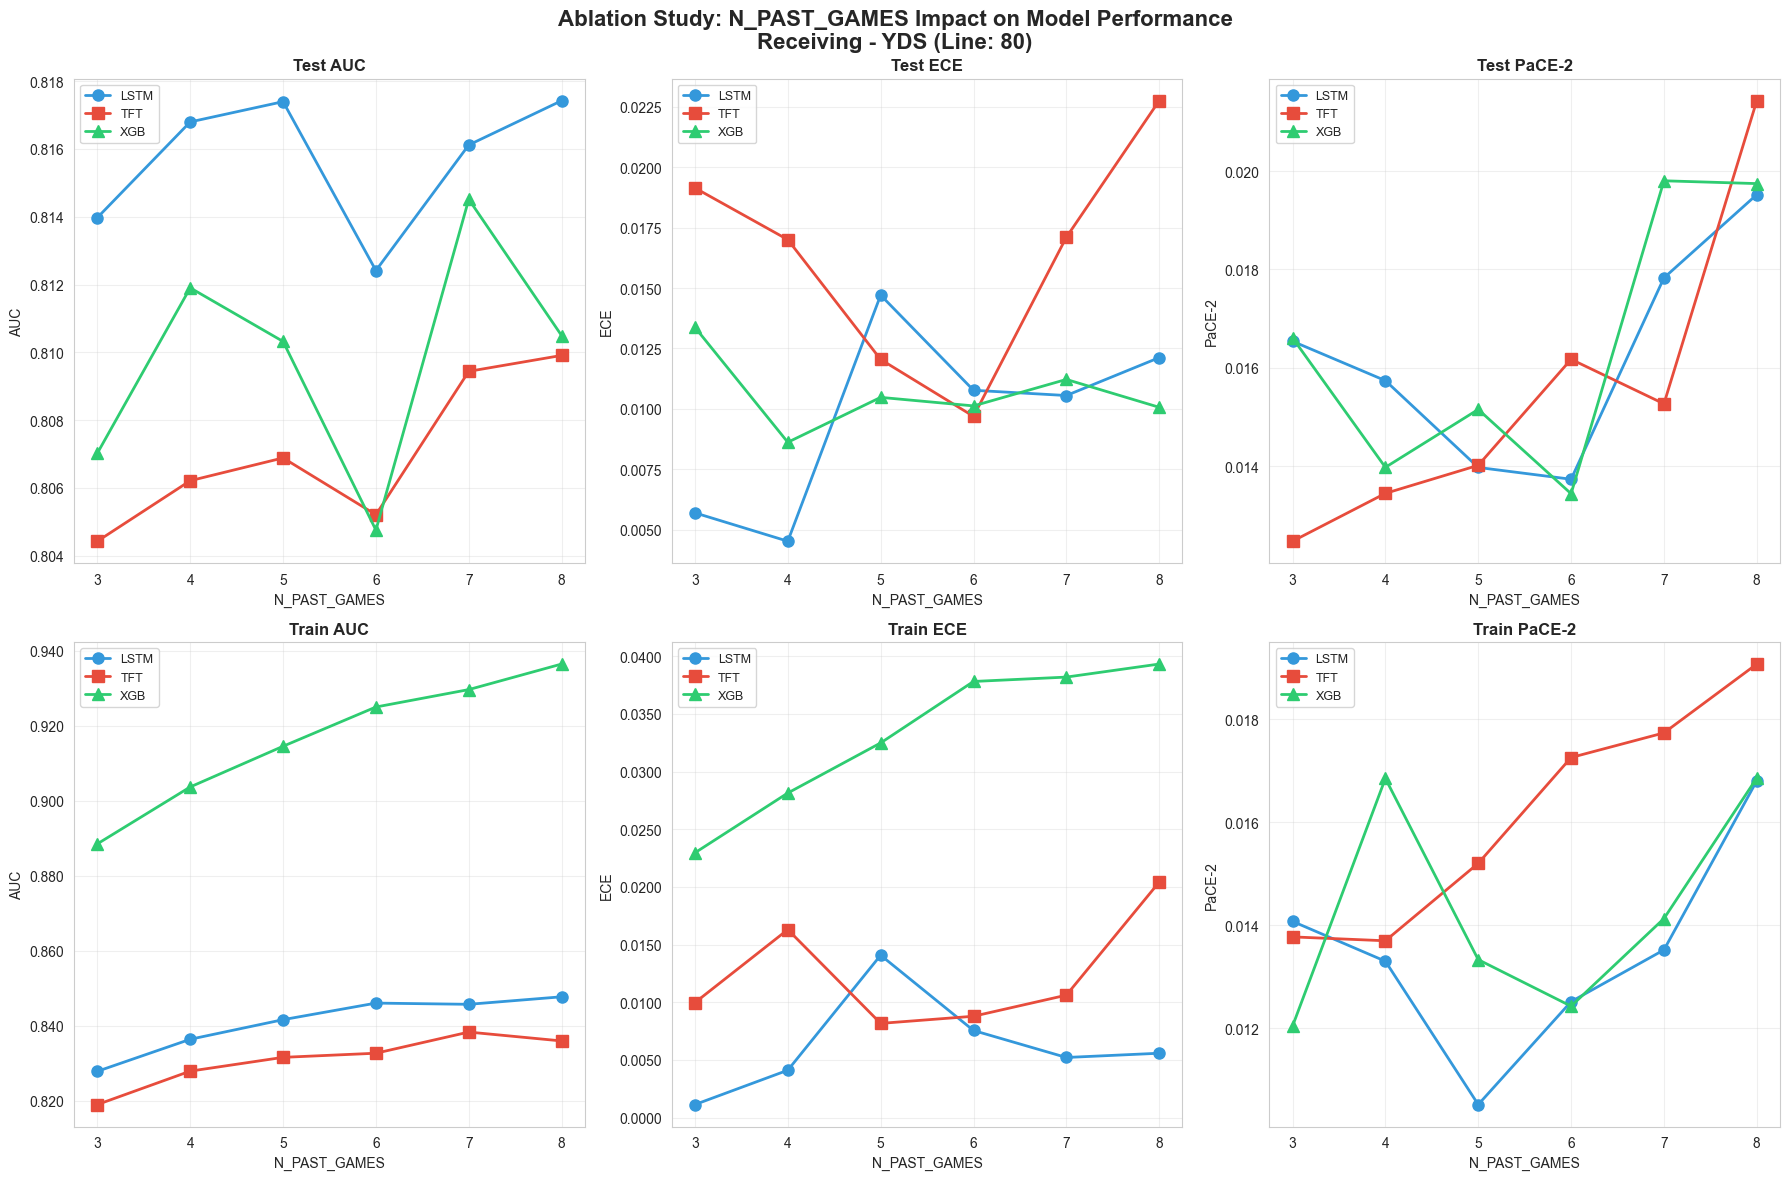


SUMMARY: Best N_PAST_GAMES for each metric

LSTM:
  Best Test AUC: 0.8174 at N_PAST_GAMES=8
  Best Test ECE: 0.0045 at N_PAST_GAMES=4
  Best Test PaCE2: 0.0195 at N_PAST_GAMES=8

TFT:
  Best Test AUC: 0.8099 at N_PAST_GAMES=8
  Best Test ECE: 0.0097 at N_PAST_GAMES=6
  Best Test PaCE2: 0.0214 at N_PAST_GAMES=8

XGB:
  Best Test AUC: 0.8145 at N_PAST_GAMES=7
  Best Test ECE: 0.0086 at N_PAST_GAMES=4
  Best Test PaCE2: 0.0198 at N_PAST_GAMES=7

Ablation study complete!


In [9]:
"""
Ablation Study: N_PAST_GAMES Analysis
Compares LSTM, TFT, and XGBoost models across different sequence lengths
"""

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
from typing import Dict, List, Tuple

# Import custom modules
from xgb import flatten_sequences, train_xgb_classifier, XGBTrainConfig
from lstm import train_dual_head_classifier, TrainConfig as LSTMTrainConfig
from tft import train_tft_classifier, TrainConfig as TFTTrainConfig
from data_prep import add_over_under_label, prepare_receiving_sequences
from metrics import compute_ece, compute_pace
from sklearn.metrics import roc_auc_score


# Configuration
YARD_TYPE = "receiving"
STAT_COL = "YDS"
LINE_VALUE = 80
HIDDEN_SIZE = 128
D_MODEL = 128
N_PAST_GAMES_RANGE = [3, 4, 5, 6, 7, 8]  # Values to test

# Training configurations
LSTM_EPOCHS = 10
TFT_EPOCHS = 10
XGB_ESTIMATORS = 300
BATCH_SIZE = 64
LEARNING_RATE = 1e-3


def train_and_evaluate_lstm(
    X_train: np.ndarray,
    y_train: np.ndarray,
    lengths_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    lengths_test: np.ndarray,
    hidden_size: int,
    n_past_games: int
) -> Dict[str, float]:
    """Train LSTM model and return metrics"""
    
    cfg = LSTMTrainConfig(
        n_epochs=LSTM_EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        device="auto",
        verbose=False,
    )
    
    print(f"  Training LSTM (n_past={n_past_games})...", end=" ")
    train_result = train_dual_head_classifier(
        X=X_train,
        y=y_train,
        lengths=lengths_train,
        hidden_size=hidden_size,
        cfg=cfg,
    )
    
    model = train_result["model"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Train metrics
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    len_train_t = torch.tensor(lengths_train, dtype=torch.long).to(device)
    
    with torch.no_grad():
        _, logits_train = model(X_train_t, len_train_t)
        probs_train = torch.sigmoid(logits_train).cpu().numpy()
    
    y_true_train = np.asarray(y_train)
    auc_train = roc_auc_score(y_true_train, probs_train)
    ece_train = compute_ece(y_true_train, probs_train)
    pace2_train = compute_pace(y_true_train, probs_train, L=2)
    
    # Test metrics
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    len_test_t = torch.tensor(lengths_test, dtype=torch.long).to(device)
    
    with torch.no_grad():
        _, logits_test = model(X_test_t, len_test_t)
        probs_test = torch.sigmoid(logits_test).cpu().numpy()
    
    y_true_test = np.asarray(y_test)
    auc_test = roc_auc_score(y_true_test, probs_test)
    ece_test = compute_ece(y_true_test, probs_test)
    pace2_test = compute_pace(y_true_test, probs_test, L=2)
    
    print("Done")
    
    return {
        "train_auc": auc_train,
        "train_ece": ece_train,
        "train_pace2": pace2_train,
        "test_auc": auc_test,
        "test_ece": ece_test,
        "test_pace2": pace2_test,
    }


def train_and_evaluate_tft(
    X_train: np.ndarray,
    y_train: np.ndarray,
    lengths_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    lengths_test: np.ndarray,
    d_model: int,
    n_past_games: int
) -> Dict[str, float]:
    """Train TFT model and return metrics"""
    
    cfg = TFTTrainConfig(
        n_epochs=TFT_EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LEARNING_RATE,
        device="auto",
        verbose=False,
    )
    
    print(f"  Training TFT (n_past={n_past_games})...", end=" ")
    train_result = train_tft_classifier(
        X=X_train,
        y=y_train,
        lengths=lengths_train,
        d_model=d_model,
        n_heads=4,
        num_layers=2,
        dropout=0.1,
        cfg=cfg,
    )
    
    model = train_result["model"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Train metrics
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    len_train_t = torch.tensor(lengths_train, dtype=torch.long).to(device)
    
    with torch.no_grad():
        _, logits_train = model(X_train_t, len_train_t)
        probs_train = torch.sigmoid(logits_train).cpu().numpy()
    
    y_true_train = np.asarray(y_train)
    auc_train = roc_auc_score(y_true_train, probs_train)
    ece_train = compute_ece(y_true_train, probs_train)
    pace2_train = compute_pace(y_true_train, probs_train, L=2)
    
    # Test metrics
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    len_test_t = torch.tensor(lengths_test, dtype=torch.long).to(device)
    
    with torch.no_grad():
        _, logits_test = model(X_test_t, len_test_t)
        probs_test = torch.sigmoid(logits_test).cpu().numpy()
    
    y_true_test = np.asarray(y_test)
    auc_test = roc_auc_score(y_true_test, probs_test)
    ece_test = compute_ece(y_true_test, probs_test)
    pace2_test = compute_pace(y_true_test, probs_test, L=2)
    
    print("Done")
    
    return {
        "train_auc": auc_train,
        "train_ece": ece_train,
        "train_pace2": pace2_train,
        "test_auc": auc_test,
        "test_ece": ece_test,
        "test_pace2": pace2_test,
    }


def train_and_evaluate_xgb(
    X_train: np.ndarray,
    y_train: np.ndarray,
    lengths_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    lengths_test: np.ndarray,
    n_past_games: int
) -> Dict[str, float]:
    """Train XGBoost model and return metrics"""
    
    cfg = XGBTrainConfig(
        n_estimators=XGB_ESTIMATORS,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        verbose=False,
    )
    
    print(f"  Training XGBoost (n_past={n_past_games})...", end=" ")
    train_result = train_xgb_classifier(
        X=X_train,
        y=y_train,
        lengths=lengths_train,
        cfg=cfg,
    )
    
    model = train_result["model"]
    
    # Train metrics
    X_train_flat = flatten_sequences(X_train)
    y_train_np = np.asarray(y_train, dtype=float)
    train_probs = model.predict_proba(X_train_flat)[:, 1]
    
    auc_train = roc_auc_score(y_train_np, train_probs)
    ece_train = compute_ece(y_train_np, train_probs)
    pace2_train = compute_pace(y_train_np, train_probs, L=2)
    
    # Test metrics
    X_test_flat = flatten_sequences(X_test)
    y_test_np = np.asarray(y_test, dtype=float)
    test_probs = model.predict_proba(X_test_flat)[:, 1]
    
    auc_test = roc_auc_score(y_test_np, test_probs)
    ece_test = compute_ece(y_test_np, test_probs)
    pace2_test = compute_pace(y_test_np, test_probs, L=2)
    
    print("Done")
    
    return {
        "train_auc": auc_train,
        "train_ece": ece_train,
        "train_pace2": pace2_train,
        "test_auc": auc_test,
        "test_ece": ece_test,
        "test_pace2": pace2_test,
    }


def run_ablation_study() -> Dict:
    """Run ablation study across different N_PAST_GAMES values"""
    
    print("="*70)
    print("ABLATION STUDY: N_PAST_GAMES Analysis")
    print("="*70)
    print(f"Yard Type: {YARD_TYPE}")
    print(f"Stat Column: {STAT_COL}")
    print(f"Line Value: {LINE_VALUE}")
    print(f"Testing N_PAST_GAMES: {N_PAST_GAMES_RANGE}")
    print("="*70 + "\n")
    
    # Load data once
    train_df = pd.read_csv(f"data/{YARD_TYPE}_2019_2023.csv")
    test_df = pd.read_csv(f"data/{YARD_TYPE}_24tocurrent.csv")
    
    train_df = add_over_under_label(train_df, stat_col=STAT_COL, 
                                    line_value=LINE_VALUE, new_col="over_label")
    test_df = add_over_under_label(test_df, stat_col=STAT_COL, 
                                   line_value=LINE_VALUE, new_col="over_label")
    
    # Store results
    results = {
        "lstm": [],
        "tft": [],
        "xgb": [],
    }
    
    # Run experiments for each N_PAST_GAMES value
    for n_past in N_PAST_GAMES_RANGE:
        print(f"\n{'='*70}")
        print(f"Testing N_PAST_GAMES = {n_past}")
        print(f"{'='*70}")
        
        # Prepare sequences
        X_train, y_train, lengths_train, _ = prepare_receiving_sequences(
            train_df,
            n_past_games=n_past,
            target_col="over_label",
        )
        
        X_test, y_test, lengths_test, _ = prepare_receiving_sequences(
            test_df,
            n_past_games=n_past,
            target_col="over_label",
        )
        
        print(f"  Train samples: {len(y_train)}")
        print(f"  Test samples: {len(y_test)}")
        
        # Train and evaluate each model
        lstm_metrics = train_and_evaluate_lstm(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            HIDDEN_SIZE, n_past
        )
        results["lstm"].append({"n_past": n_past, **lstm_metrics})
        
        tft_metrics = train_and_evaluate_tft(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            D_MODEL, n_past
        )
        results["tft"].append({"n_past": n_past, **tft_metrics})
        
        xgb_metrics = train_and_evaluate_xgb(
            X_train, y_train, lengths_train,
            X_test, y_test, lengths_test,
            n_past
        )
        results["xgb"].append({"n_past": n_past, **xgb_metrics})
        
        # Print summary
        print(f"\n  Results for N_PAST_GAMES = {n_past}:")
        print(f"    LSTM   - Test AUC: {lstm_metrics['test_auc']:.4f}, ECE: {lstm_metrics['test_ece']:.4f}, PaCE2: {lstm_metrics['test_pace2']:.4f}")
        print(f"    TFT    - Test AUC: {tft_metrics['test_auc']:.4f}, ECE: {tft_metrics['test_ece']:.4f}, PaCE2: {tft_metrics['test_pace2']:.4f}")
        print(f"    XGBoost - Test AUC: {xgb_metrics['test_auc']:.4f}, ECE: {xgb_metrics['test_ece']:.4f}, PaCE2: {xgb_metrics['test_pace2']:.4f}")
    
    return results


def plot_results(results: Dict):
    """Create visualization of ablation study results"""
    
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (15, 10)
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Ablation Study: N_PAST_GAMES Impact on Model Performance\n{YARD_TYPE.title()} - {STAT_COL} (Line: {LINE_VALUE})', 
                 fontsize=16, fontweight='bold')
    
    metrics = ['auc', 'ece', 'pace2']
    splits = ['test', 'train']
    
    colors = {'lstm': '#3498db', 'tft': '#e74c3c', 'xgb': '#2ecc71'}
    markers = {'lstm': 'o', 'tft': 's', 'xgb': '^'}
    
    for split_idx, split in enumerate(splits):
        for metric_idx, metric in enumerate(metrics):
            ax = axes[split_idx, metric_idx]
            
            for model_name in ['lstm', 'tft', 'xgb']:
                n_past_values = [r['n_past'] for r in results[model_name]]
                metric_values = [r[f'{split}_{metric}'] for r in results[model_name]]
                
                ax.plot(n_past_values, metric_values, 
                       marker=markers[model_name], 
                       color=colors[model_name], 
                       label=model_name.upper(),
                       linewidth=2, 
                       markersize=8)
            
            # Formatting
            metric_name = metric.upper() if metric != 'pace2' else 'PaCE-2'
            ax.set_title(f'{split.capitalize()} {metric_name}', fontsize=12, fontweight='bold')
            ax.set_xlabel('N_PAST_GAMES', fontsize=10)
            ax.set_ylabel(metric_name, fontsize=10)
            ax.legend(loc='best', fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_xticks(N_PAST_GAMES_RANGE)
            
            # Higher is better for AUC and PaCE2, lower is better for ECE
            if metric in ['auc', 'pace2']:
                ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.3f}'))
            else:
                ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.4f}'))
    
    plt.tight_layout()
    
    # Save plot
    os.makedirs("ablation_results", exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_path = f"ablation_results/ablation_study_{YARD_TYPE}_{STAT_COL}_{timestamp}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to: {plot_path}")
    
    plt.show()


def save_results(results: Dict):
    """Save results to JSON file"""
    os.makedirs("ablation_results", exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    results_path = f"ablation_results/ablation_results_{YARD_TYPE}_{STAT_COL}_{timestamp}.json"
    
    results_data = {
        "timestamp": datetime.now().isoformat(),
        "configuration": {
            "yard_type": YARD_TYPE,
            "stat_col": STAT_COL,
            "line_value": LINE_VALUE,
            "hidden_size": HIDDEN_SIZE,
            "d_model": D_MODEL,
            "n_past_games_range": N_PAST_GAMES_RANGE,
        },
        "results": results,
    }
    
    with open(results_path, "w") as f:
        json.dump(results_data, f, indent=2)
    
    print(f"Results saved to: {results_path}")


def print_summary(results: Dict):
    """Print summary of best configurations"""
    print("\n" + "="*70)
    print("SUMMARY: Best N_PAST_GAMES for each metric")
    print("="*70)
    
    for model_name in ['lstm', 'tft', 'xgb']:
        print(f"\n{model_name.upper()}:")
        model_results = results[model_name]
        
        # Best test AUC
        best_auc = max(model_results, key=lambda x: x['test_auc'])
        print(f"  Best Test AUC: {best_auc['test_auc']:.4f} at N_PAST_GAMES={best_auc['n_past']}")
        
        # Best test ECE (lower is better)
        best_ece = min(model_results, key=lambda x: x['test_ece'])
        print(f"  Best Test ECE: {best_ece['test_ece']:.4f} at N_PAST_GAMES={best_ece['n_past']}")
        
        # Best test PaCE2
        best_pace = max(model_results, key=lambda x: x['test_pace2'])
        print(f"  Best Test PaCE2: {best_pace['test_pace2']:.4f} at N_PAST_GAMES={best_pace['n_past']}")


if __name__ == "__main__":
    # Run ablation study
    results = run_ablation_study()
    
    # Save results
    save_results(results)
    
    # Plot results
    plot_results(results)
    
    # Print summary
    print_summary(results)
    
    print("\n" + "="*70)
    print("Ablation study complete!")
    print("="*70)

# Ablation Study 3: Calibration Methods

Here we will compare raw sigmoid outputs, Platt scaling, and isotonic regression calibration for XGBoost receiving yards

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

from data_prep import add_over_under_label, prepare_receiving_sequences
from xgb import XGBTrainConfig, train_xgb_classifier, flatten_sequences
from metrics import compute_ece, compute_pace

train_df = pd.read_csv("data/receiving_2019_2023.csv")
test_df = pd.read_csv("data/receiving_24tocurrent.csv")


STAT_COL    = "YDS"   
LINE_VALUE  = 37.5    
N_PAST_GAMES = 5

train_df = add_over_under_label(
    df=train_df,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    new_col="over_label",
)
test_df = add_over_under_label(
    df=test_df,
    stat_col=STAT_COL,
    line_value=LINE_VALUE,
    new_col="over_label",
)

X_train, y_train, lengths_train, _ = prepare_receiving_sequences(
    train_df,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)
X_test, y_test, lengths_test, _ = prepare_receiving_sequences(
    test_df,
    n_past_games=N_PAST_GAMES,
    target_col="over_label",
)


xgb_cfg = XGBTrainConfig(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    verbose=False,
)

xgb_result = train_xgb_classifier(
    X=X_train,
    y=y_train,
    lengths=lengths_train,
    cfg=xgb_cfg,
)

xgb_model = xgb_result["model"]

# Flatten sequences (N, T, E) -> (N, T*E)
X_train_flat = flatten_sequences(X_train)
X_test_flat  = flatten_sequences(X_test)

# Convert y to numpy
if "torch" in str(type(y_train)):
    y_train_np = y_train.detach().cpu().numpy().astype(int)
else:
    y_train_np = np.asarray(y_train, dtype=int)

if "torch" in str(type(y_test)):
    y_test_np = y_test.detach().cpu().numpy().astype(int)
else:
    y_test_np = np.asarray(y_test, dtype=int)


/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:03:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [2]:
probs_train_raw = xgb_model.predict_proba(X_train_flat)[:, 1]
probs_test_raw  = xgb_model.predict_proba(X_test_flat)[:, 1]

auc_raw  = roc_auc_score(y_test_np, probs_test_raw)
ece_raw  = compute_ece(y_test_np, probs_test_raw, n_bins=10)
pace_raw = compute_pace(y_test_np, probs_test_raw, L=2, M=2000)

print("=== RAW XGB on TEST ===")
print(f"AUC  : {auc_raw:.4f}")
print(f"ECE  : {ece_raw:.4f}")
print(f"PaCE2: {pace_raw:.44f}  (random 2-leg parlays)\n")

=== RAW XGB on TEST ===
AUC  : 0.7827
ECE  : 0.0134
PaCE2: 0.16642589084719497383169084514520363882184029  (random 2-leg parlays)



In [3]:
platt = LogisticRegression(max_iter=1000)
platt.fit(probs_train_raw.reshape(-1, 1), y_train_np)

probs_test_platt = platt.predict_proba(probs_test_raw.reshape(-1, 1))[:, 1]
probs_test_platt = np.clip(probs_test_platt, 1e-6, 1 - 1e-6)

auc_platt  = roc_auc_score(y_test_np, probs_test_platt)
ece_platt  = compute_ece(y_test_np, probs_test_platt, n_bins=10)
pace_platt = compute_pace(y_test_np, probs_test_platt, L=2, M=2000)

print("=== Platt (Sigmoid) on TEST ===")
print(f"AUC  : {auc_platt:.4f}")
print(f"ECE  : {ece_platt:.4f}")
print(f"PaCE2: {pace_platt:.4f}  (random 2-leg parlays)\n")

=== Platt (Sigmoid) on TEST ===
AUC  : 0.7827
ECE  : 0.0454
PaCE2: 0.1751  (random 2-leg parlays)



In [7]:
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(probs_train_raw, y_train_np)

probs_test_iso = iso.predict(probs_test_raw)
probs_test_iso = np.clip(probs_test_iso, 1e-6, 1 - 1e-6)

auc_iso  = roc_auc_score(y_test_np, probs_test_iso)
ece_iso  = compute_ece(y_test_np, probs_test_iso, n_bins=10)
pace_iso = compute_pace(y_test_np, probs_test_iso, L=2, M=2000)

print("=== Isotonic Regression on TEST ===")
print(f"AUC  : {auc_iso:.4f}")
print(f"ECE  : {ece_iso:.4f}")
print(f"PaCE2: {pace_iso:.4f}  (random 2-leg parlays)\n")


=== Isotonic Regression on TEST ===
AUC  : 0.7823
ECE  : 0.0373
PaCE2: 0.1650  (random 2-leg parlays)



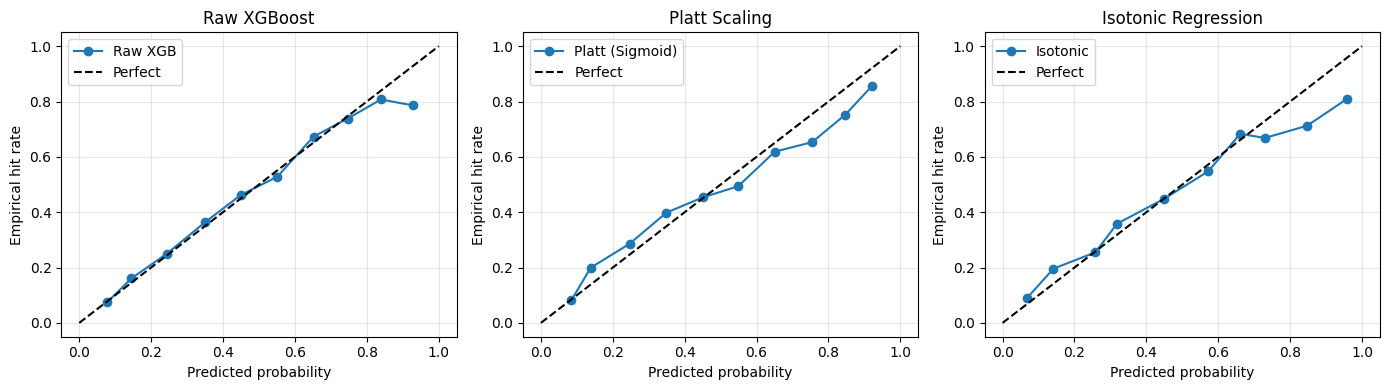

In [8]:
prob_true_raw,   prob_pred_raw   = calibration_curve(y_test_np, probs_test_raw,   n_bins=10, strategy="uniform")
prob_true_platt, prob_pred_platt = calibration_curve(y_test_np, probs_test_platt, n_bins=10, strategy="uniform")
prob_true_iso,   prob_pred_iso   = calibration_curve(y_test_np, probs_test_iso,   n_bins=10, strategy="uniform")

plt.figure(figsize=(14, 4))

ax1 = plt.subplot(1, 3, 1)
ax1.plot(prob_pred_raw, prob_true_raw, "o-", label="Raw XGB")
ax1.plot([0, 1], [0, 1], "k--", label="Perfect")
ax1.set_title("Raw XGBoost")
ax1.set_xlabel("Predicted probability")
ax1.set_ylabel("Empirical hit rate")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(1, 3, 2)
ax2.plot(prob_pred_platt, prob_true_platt, "o-", label="Platt (Sigmoid)")
ax2.plot([0, 1], [0, 1], "k--", label="Perfect")
ax2.set_title("Platt Scaling")
ax2.set_xlabel("Predicted probability")
ax2.set_ylabel("Empirical hit rate")
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Isotonic ---
ax3 = plt.subplot(1, 3, 3)
ax3.plot(prob_pred_iso, prob_true_iso, "o-", label="Isotonic")
ax3.plot([0, 1], [0, 1], "k--", label="Perfect")
ax3.set_title("Isotonic Regression")
ax3.set_xlabel("Predicted probability")
ax3.set_ylabel("Empirical hit rate")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Expectated Calibration Error is actually better on the raw XGBoost model with similar AUC values post calibration